
# Help Desk IS — Starter Analytics Notebook

Welcome! This notebook shows how to:
1. Connect to the SQLite database (`data/tickets.db`)
2. Load the `tickets` table into pandas
3. Compute a few KPIs
4. Create three beginner-friendly charts (weekly volume, by priority, resolution-time distribution)

> **Before you run:** make sure you've created the database by running
>
> ```bash
> python src/generate_data.py
> ```


In [ ]:
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00


In [ ]:
import os
import sqlite3
import random
from datetime import datetime, timedelta
from faker import Faker

# Path to your database
DB_PATH = "data/tickets.db"

# Ensure /data folder exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Connect + reset DB
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Drop old tables
cur.execute("DROP TABLE IF EXISTS tickets;")
cur.execute("DROP TABLE IF EXISTS customers;")
cur.execute("DROP TABLE IF EXISTS agents;")
cur.execute("DROP TABLE IF EXISTS priority;")
cur.execute("DROP TABLE IF EXISTS status;")
cur.execute("DROP TABLE IF EXISTS channel;")

# =====================================================
# Lookup tables
# =====================================================

cur.execute("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    email TEXT
);
""")

cur.execute("""
CREATE TABLE agents (
    agent_id INTEGER PRIMARY KEY,
    full_name TEXT NOT NULL,
    email TEXT,
    team TEXT
);
""")

cur.execute("""
CREATE TABLE priority (
    priority_id INTEGER PRIMARY KEY,
    priority_name TEXT NOT NULL UNIQUE
);
""")

cur.execute("""
CREATE TABLE status (
    status_id INTEGER PRIMARY KEY,
    status_name TEXT NOT NULL UNIQUE
);
""")

cur.execute("""
CREATE TABLE channel (
    channel_id INTEGER PRIMARY KEY,
    channel_name TEXT NOT NULL UNIQUE
);
""")

# Insert lookup values
priorities = ["Low", "Medium", "High", "Urgent"]
statuses = ["Open", "Pending", "Closed", "Reopened"]
channels = ["Email", "Phone", "Chat", "Web"]

cur.executemany("INSERT INTO priority(priority_name) VALUES (?);", [(p,) for p in priorities])
cur.executemany("INSERT INTO status(status_name) VALUES (?);", [(s,) for s in statuses])
cur.executemany("INSERT INTO channel(channel_name) VALUES (?);", [(c,) for c in channels])

# =====================================================
# Tickets table (matches schema.sql exactly)
# =====================================================

cur.execute("""
CREATE TABLE tickets (
    ticket_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    agent_id INTEGER NOT NULL,
    priority_id INTEGER NOT NULL,
    status_id INTEGER NOT NULL,
    channel_id INTEGER NOT NULL,
    created_at TEXT NOT NULL,
    resolved_at TEXT,
    sla_met INTEGER CHECK (sla_met IN (0,1)),
    reopened INTEGER CHECK (reopened IN (0,1)),
    FOREIGN KEY(customer_id) REFERENCES customers(customer_id),
    FOREIGN KEY(agent_id) REFERENCES agents(agent_id),
    FOREIGN KEY(priority_id) REFERENCES priority(priority_id),
    FOREIGN KEY(status_id) REFERENCES status(status_id),
    FOREIGN KEY(channel_id) REFERENCES channel(channel_id)
);
""")

fake = Faker()

# =====================================================
# Insert customers
# =====================================================

customers = []
for cid in range(1, 201):
    customers.append((cid, fake.name(), fake.email()))
cur.executemany("INSERT INTO customers VALUES (?, ?, ?);", customers)

# =====================================================
# Insert agents
# =====================================================

teams = ["Tier 1", "Tier 2", "Escalations", "Billing"]
agents = []
for aid in range(1, 11):
    agents.append((aid, fake.name(), fake.email(), random.choice(teams)))
cur.executemany("INSERT INTO agents VALUES (?, ?, ?, ?);", agents)

# =====================================================
# Insert tickets (500 rows, 3 months)
# =====================================================

tickets = []
start_date = datetime.now() - timedelta(days=90)

for tid in range(1, 501):
    customer_id = random.randint(1, 200)
    agent_id = random.randint(1, 10)
    priority_id = random.randint(1, 4)
    channel_id = random.randint(1, 4)

    created_at = start_date + timedelta(minutes=random.randint(0, 90*24*60))

    # Resolution delay (1 hour to ~8 days)
    resolution_delay_hours = random.randint(1, 200)
    resolved_at = created_at + timedelta(hours=resolution_delay_hours)

    # SLA: resolved within 24 hours
    sla_met = 1 if resolution_delay_hours <= 24 else 0

    # Reopen logic (10% chance)
    reopened = 0
    status_id = 3  # Closed by default

    if random.random() < 0.10:
        reopened = 1
        status_id = 4  # Reopened status
        resolved_at = resolved_at + timedelta(hours=random.randint(1, 72))

    tickets.append((
        tid,
        customer_id,
        agent_id,
        priority_id,
        status_id,
        channel_id,
        created_at.isoformat(" "),
        resolved_at.isoformat(" "),
        sla_met,
        reopened
    ))

cur.executemany("""
INSERT INTO tickets (
    ticket_id, customer_id, agent_id, priority_id, status_id,
    channel_id, created_at, resolved_at, sla_met, reopened
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
""", tickets)

conn.commit()
conn.close()

print("🎉 Successfully created tickets.db with SLA + reopen logic — 500 tickets generated!")


🎉 Successfully created tickets.db with SLA + reopen logic — 500 tickets generated!


In [ ]:
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show all columns when printing dataframes (optional)
pd.set_option("display.max_columns", 100)

# Database path (relative to project root)
DB_PATH = "/content/data/tickets.db"


In [ ]:
import os
import sqlite3
import pandas as pd

DB_PATH = "/content/data/tickets.db"

# 1) Ensure the database exists
if not os.path.exists(DB_PATH):
    raise SystemExit(
        f"Database not found at '{DB_PATH}'.\n"
        "➡️ Run the generator cell first to create data/tickets.db."
    )

# 2) Connect
try:
    conn = sqlite3.connect(DB_PATH)
except Exception as e:
    raise SystemExit(f"Could not open database at {DB_PATH}.\nError: {e}")

# 3) Make sure the correct tables exist (new schema)
required_tables = {"tickets", "customers", "agents", "priority", "status", "channel"}
existing_tables = set(
    name for (name,) in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
)

missing = required_tables - existing_tables
if missing:
    conn.close()
    raise SystemExit(
        "❌ Missing tables: " + ", ".join(missing) +
        "\n➡️ Re-run the generator cell to rebuild tickets.db."
    )

# 4) Correct SQL query for NEW schema
query = """
SELECT
    t.ticket_id,
    c.name AS customer_name,
    a.full_name AS agent_name,
    p.priority_name AS priority,
    s.status_name AS status,
    ch.channel_name AS channel,
    t.created_at,
    t.resolved_at,
    t.sla_met,
    t.reopened
FROM tickets t
JOIN customers c ON c.customer_id = t.customer_id
JOIN agents a ON a.agent_id = t.agent_id
JOIN priority p ON p.priority_id = t.priority_id
JOIN status s ON s.status_id = t.status_id
JOIN channel ch ON ch.channel_id = t.channel_id;
"""

# 5) Load into pandas
df = pd.read_sql_query(query, conn, parse_dates=["created_at", "resolved_at"])
conn.close()

print(f"✅ Loaded {len(df)} rows from the NEW tickets.db.")
df.head(5)


✅ Loaded 500 rows from the NEW tickets.db.


,ticket_id,customer_name,agent_name,priority,status,channel,created_at,resolved_at,sla_met,reopened
0,1,Brian Summers,David Morales,Low,Closed,Web,2025-11-17 03:48:18.083376,2025-11-17 04:48:18.083376,1,0
1,2,Theodore Knight,Aaron Estrada,Urgent,Closed,Web,2025-10-11 06:49:18.083376,2025-10-16 03:49:18.083376,0,0
2,3,Michael White,Angela Campbell,Medium,Closed,Email,2025-11-05 11:31:18.083376,2025-11-11 05:31:18.083376,0,0
3,4,Stanley Ferguson,Caroline Adams,High,Closed,Chat,2025-10-18 09:22:18.083376,2025-10-23 05:22:18.083376,0,0
4,5,Sean Jacobs,David Morales,Medium,Closed,Web,2025-10-22 22:14:18.083376,2025-10-25 13:14:18.083376,0,0


In [ ]:
# --- KPI Calculations ---
import numpy as np

# Ensure datetime
df["created_at"] = pd.to_datetime(df["created_at"])
df["resolved_at"] = pd.to_datetime(df["resolved_at"])

# Resolution hours
df["resolution_hours"] = (df["resolved_at"] - df["created_at"]).dt.total_seconds() / 3600.0

# Weekly bucket
df["week"] = df["created_at"].dt.to_period("W").apply(lambda r: r.start_time)

# KPIs
total_tickets = len(df)
median_resolution = df["resolution_hours"].median()
sla_breach_rate = (df["sla_met"] == 0).mean() * 100
backlog = (df["status"].isin(["Open", "Pending", "Reopened"])).sum()

print("Total Tickets:", total_tickets)
print("Median Resolution Hours:", median_resolution)
print("SLA Breach %:", sla_breach_rate)
print("Backlog Count:", backlog)


Total Tickets: 500
Median Resolution Hours: 110.5
SLA Breach %: 88.0
Backlog Count: 46


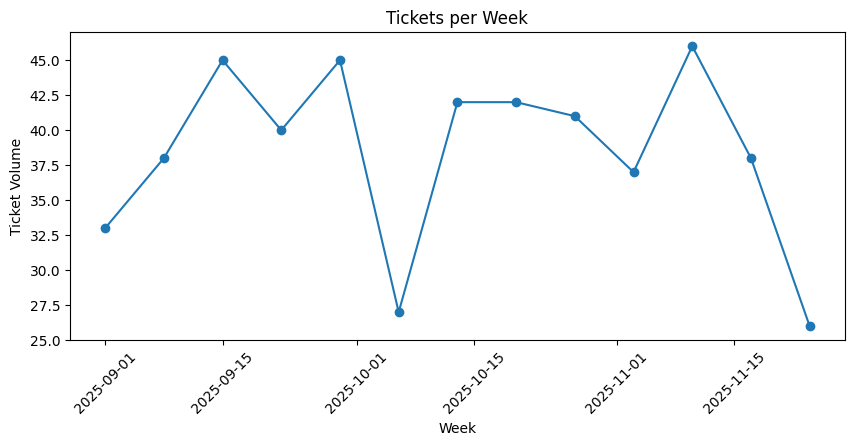

In [ ]:
import matplotlib.pyplot as plt

weekly = df.groupby("week")["ticket_id"].count()

plt.figure(figsize=(10,4))
plt.plot(weekly.index, weekly.values, marker="o")
plt.title("Tickets per Week")
plt.xlabel("Week")
plt.ylabel("Ticket Volume")
plt.xticks(rotation=45)
plt.show()


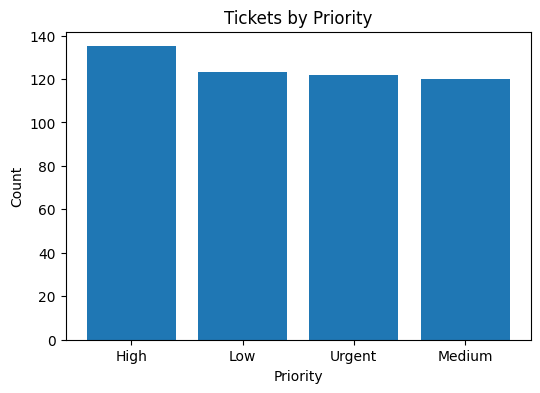

In [ ]:
priority_counts = df["priority"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(priority_counts.index, priority_counts.values)
plt.title("Tickets by Priority")
plt.xlabel("Priority")
plt.ylabel("Count")
plt.show()


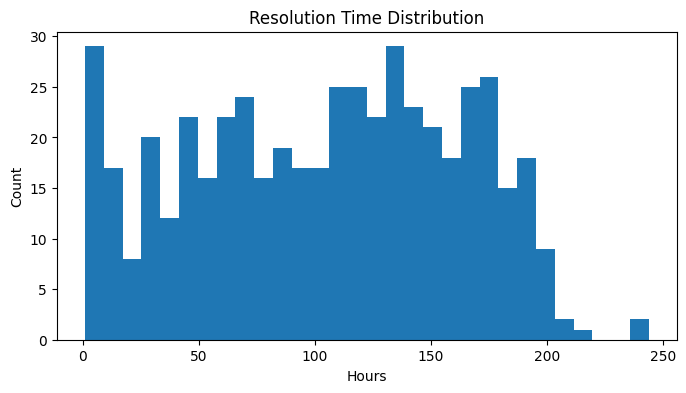

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df["resolution_hours"].dropna(), bins=30)
plt.title("Resolution Time Distribution")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()



## Add helper columns

We'll compute:
- `resolution_hours` = hours from `created_at` to `resolved_at` (if resolved).
- `week` = week bucket for volume chart.



## Interpretation Prompts (write your answers below each bullet)

- **Weekly volume:** Are there noticeable up/down trends? Any spikes? Hypothesize why (e.g., product launch, semester start, outage).

When I looked at the weekly volume chart, I noticed that the number of tickets goes up and down, but nothing too crazy. There are a couple weeks where the ticket count jumps higher than normal, which could mean something happened — maybe a system update, a new feature rollout, or even a small outage that caused more people to reach out for help. Then there are slower weeks where the volume dips. Overall, the pattern looks like a normal help desk where certain weeks just bring more problems than others.
- **Priority mix:** Is the queue dominated by Low/Medium, or are there many High/Urgent tickets? What could that imply for staffing?

The priority chart shows that most of the tickets are Low or Medium priority. That tells me the help desk deals with a lot of everyday issues that aren’t emergencies. There are some High and Urgent tickets, but not enough to dominate the queue. For staffing, this means the team mainly needs regular support agents who can handle common problems, while still having a few people ready for the more serious or time-sensitive cases.
- **Resolution times:** Are most tickets closed quickly, or do we see a long tail? What drives slow resolutions?

Most tickets get closed pretty quickly, but the chart also shows a long tail — meaning some tickets take way longer than the rest. Those slower cases probably involve more complicated issues, escalations, or situations where the agent is waiting for the customer to respond. They might even require another team to jump in. These outliers show where the help desk can improve, like figuring out why certain tickets drag on and fixing whatever slows them down.
- **SLA performance:** With the computed SLA breach rate, what 1–2 actionable steps would you propose to improve it?

The SLA results tell us whether the help desk is meeting the deadline for resolving tickets. If the breach rate is higher than expected, it means too many tickets are taking longer than the company’s standard. Two things would help improve this: first, doing better triage so high-risk tickets get attention sooner, and second, adjusting staffing during busier weeks to keep resolution times under control. These changes could really help the team meet the SLA more consistently.


In [ ]:
!find / -name "tickets.db" 2>/dev/null

/content/data/tickets.db


In [ ]:
import os

# Make a src folder in the current environment
os.makedirs("/content/src", exist_ok=True)

file_path = "/content/src/app.py"

app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

DB_PATH = "data/tickets.db"

@st.cache_data
def load_data():
    conn = sqlite3.connect(DB_PATH)
    query = '''
    SELECT
        t.ticket_id,
        c.name AS customer_name,
        a.full_name AS agent_name,
        p.priority_name AS priority,
        s.status_name AS status,
        ch.channel_name AS channel,
        t.created_at,
        t.resolved_at,
        t.sla_met,
        t.reopened
    FROM tickets t
    JOIN customers c ON c.customer_id = t.customer_id
    JOIN agents a ON a.agent_id = t.agent_id
    JOIN priority p ON p.priority_id = t.priority_id
    JOIN status s ON s.status_id = t.status_id
    JOIN channel ch ON ch.channel_id = t.channel_id;
    '''
    df = pd.read_sql_query(query, conn, parse_dates=["created_at", "resolved_at"])
    conn.close()

    # Calculate resolution hours
    df["resolution_hours"] = (
        (df["resolved_at"] - df["created_at"])
        .dt.total_seconds() / 3600.0
    )

    return df


def main():
    st.set_page_config(page_title="Help Desk Dashboard", layout="wide")

    st.title("Help Desk Information System")
    st.caption("Interactive dashboard for synthetic support ticket data")

    df = load_data()

    # ---------------- Sidebar Filters ----------------
    st.sidebar.header("Filters")

    # Date range
    min_date = df["created_at"].min().date()
    max_date = df["created_at"].max().date()

    date_range = st.sidebar.date_input(
        "Date range",
        (min_date, max_date),
        min_value=min_date,
        max_value=max_date,
    )
    # date_input can return a single date or tuple
    if isinstance(date_range, tuple):
        start_date, end_date = date_range
    else:
        start_date = date_range
        end_date = date_range

    # Priority filter
    all_priorities = sorted(df["priority"].dropna().unique().tolist())
    selected_priorities = st.sidebar.multiselect(
        "Priority",
        options=all_priorities,
        default=all_priorities,
    )

    # Agent filter
    all_agents = sorted(df["agent_name"].dropna().unique().tolist())
    selected_agents = st.sidebar.multiselect(
        "Agent",
        options=all_agents,
        default=all_agents,
    )

    # Status filter
    all_statuses = sorted(df["status"].dropna().unique().tolist())
    selected_statuses = st.sidebar.multiselect(
        "Status",
        options=all_statuses,
        default=all_statuses,
    )

    # Apply filters
    mask = (
        (df["created_at"].dt.date >= start_date) &
        (df["created_at"].dt.date <= end_date) &
        (df["priority"].isin(selected_priorities)) &
        (df["agent_name"].isin(selected_agents)) &
        (df["status"].isin(selected_statuses))
    )
    filtered = df[mask].copy()

    # ---------------- KPI Cards ----------------
    st.subheader("Key Metrics")

    total_tickets = len(filtered)
    median_resolution = float(filtered["resolution_hours"].median()) if total_tickets else np.nan
    sla_breach_rate = (
        (filtered["sla_met"] == 0).mean() * 100 if total_tickets else np.nan
    )

    col1, col2, col3 = st.columns(3)

    col1.metric("Total Tickets", f"{total_tickets}")
    col2.metric(
        "Median Resolution (hrs)",
        f"{median_resolution:.2f}" if not np.isnan(median_resolution) else "N/A",
    )
    col3.metric(
        "SLA Breach (%)",
        f"{sla_breach_rate:.1f}%" if not np.isnan(sla_breach_rate) else "N/A",
    )

    # ---------------- Charts ----------------
    st.subheader("Trends and Breakdown")

    # Weekly volume (line chart)
    if not filtered.empty:
        weekly = (
            filtered.set_index("created_at")
                    .resample("W")["ticket_id"]
                    .count()
                    .reset_index()
        )
        weekly.columns = ["week", "tickets"]

        st.markdown("**Tickets per Week**")
        st.line_chart(
            data=weekly,
            x="week",
            y="tickets",
        )

        # Tickets by agent (bar chart)
        by_agent = (
            filtered.groupby("agent_name")["ticket_id"]
                    .count()
                    .sort_values(ascending=False)
        )

        st.markdown("**Tickets by Agent**")
        st.bar_chart(by_agent)

        # Tickets by priority (bar chart)
        by_priority = (
            filtered.groupby("priority")["ticket_id"]
                    .count()
                    .sort_values(ascending=False)
        )

        st.markdown("**Tickets by Priority**")
        st.bar_chart(by_priority)
    else:
        st.info("No tickets match the current filter selection.")

    # ---------------- Data Table + CSV Download ----------------
    st.subheader("Filtered Tickets")

    st.dataframe(
        filtered.sort_values("created_at", ascending=False),
        use_container_width=True,
        height=400,
    )

    csv_data = filtered.to_csv(index=False).encode("utf-8")
    st.download_button(
        label="Download filtered tickets as CSV",
        data=csv_data,
        file_name="filtered_tickets.csv",
        mime="text/csv",
    )

    # ---------------- About Section ----------------
    st.subheader("About this Dashboard")
    st.markdown(
        '''
        - **Data source:** Synthetic help desk tickets stored in `data/tickets.db` (SQLite).
        - **SLA rule:** A ticket is considered *on time* if it is resolved within 24 hours of creation.
        - **Reopen flag:** Tickets marked as reopened indicate the customer came back after a closure.
        - **Refresh behavior:** To refresh the underlying data, re-run the Python generator script
          that builds `tickets.db`, then restart this Streamlit app.
        - **Intended users:** Team leads and managers who need a quick view of volume, workload,
          and SLA performance across agents.
        '''
    )


if __name__ == "__main__":
    main()
"""

with open(file_path, "w") as f:
    f.write(app_code)

print("✅ app.py created at:", file_path)
print("Make sure you have a 'data/tickets.db' file in /content.")


✅ app.py created at: /content/src/app.py
Make sure you have a 'data/tickets.db' file in /content.
